In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../') # add parent directory to path
import fbs
from tqdm import tqdm
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d

## Basic validation
We validate the height-height correlation function for both planar and spherical surfaces. In order to obtain enough statistics, we average over many surfaces (between 100 and 1000). This is especially relevant for antipodes on spheres, as only a very small fraction of pairs of point are antipodes to each-other when compared to set of all pairs of points.

## Planar surfaces
The isotropic height-height correlation function is given by 
$$
C(r) = \left\langle \left[z(\vec{x} + \vec{r}) - z(\vec x) \right]^2 \right\rangle,
$$
where the average is taken over sufficiently large sample of $\vec x$ and orientations of $\vec r$.

We validate the expected behavior of $C(R)\propto r^{-2H}$ over 10000 pairs of points drawn from 100 generated surfaces. The deviations fall within 2.5% with more statistics converging better towards the theoretical curve with higher Hurst exponents converging slower.

Generating pairs of points...
Finished generating pairs of points.
Calculating dz using 4 threads...


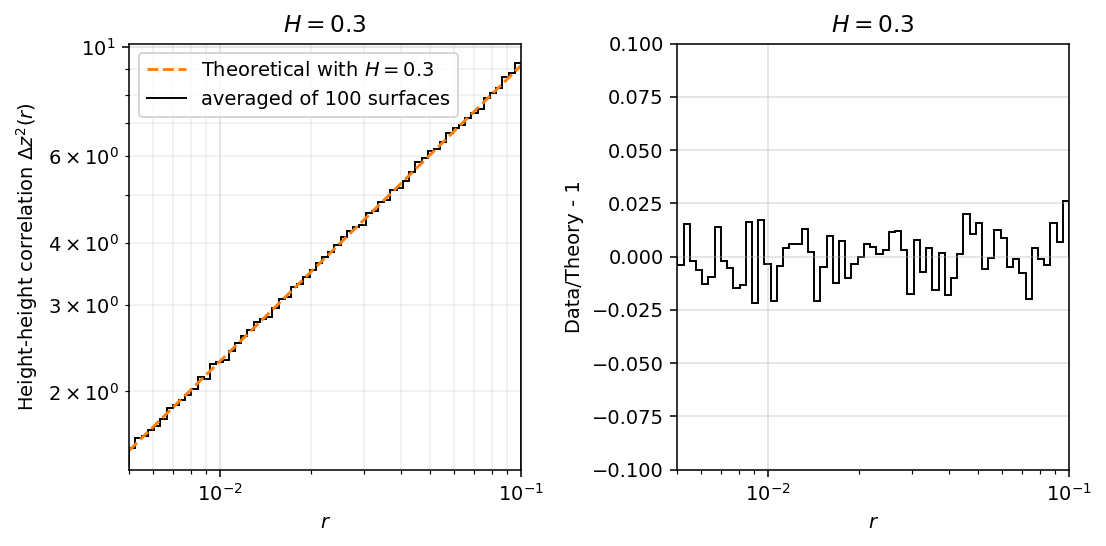

Generating pairs of points...
Finished generating pairs of points.
Calculating dz using 4 threads...


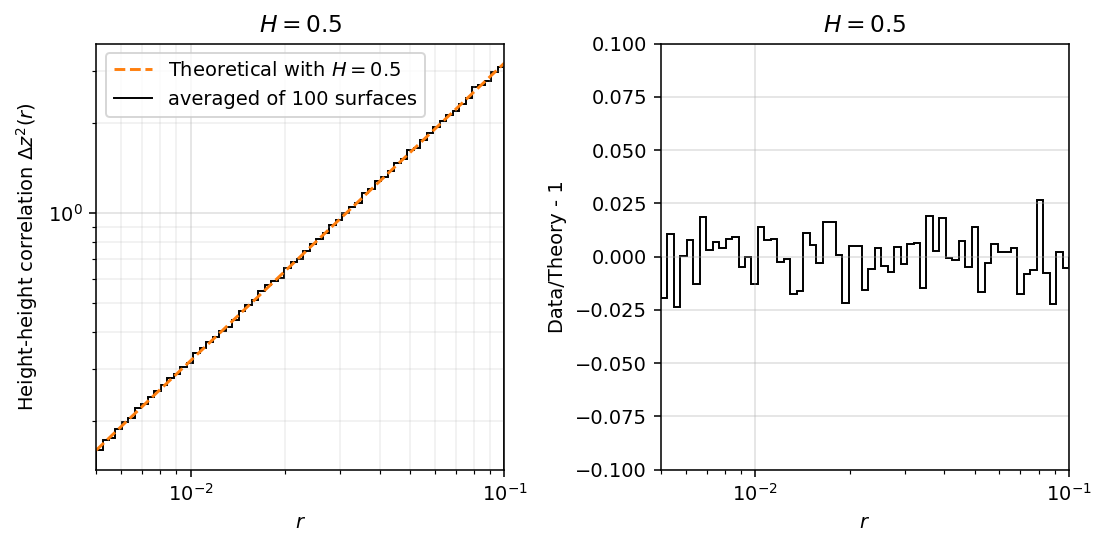

Generating pairs of points...
Finished generating pairs of points.
Calculating dz using 4 threads...


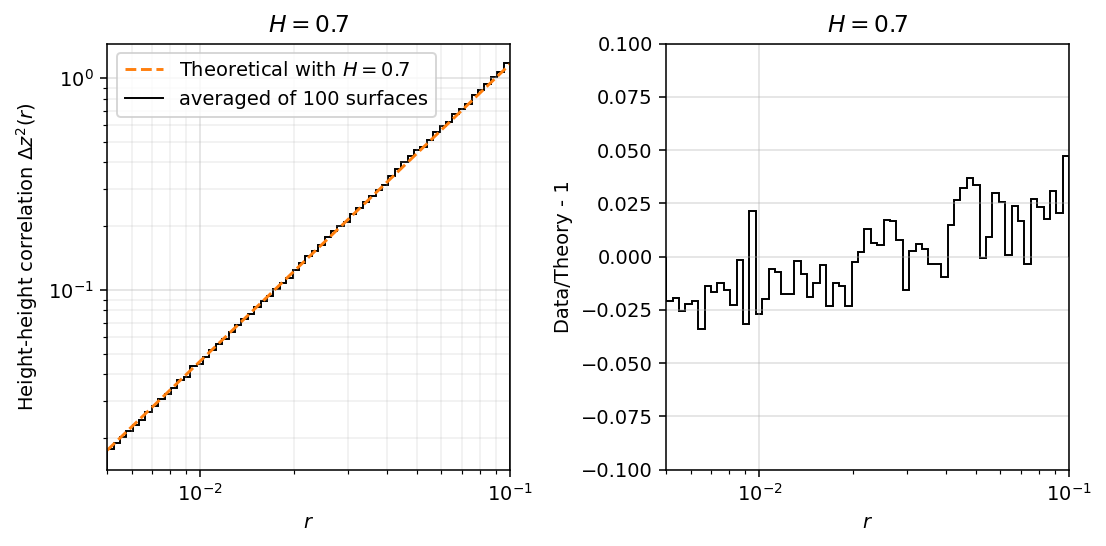

In [3]:
def calculate_dz(seeds, x1, x2, y1, y2, H, num_components, n_fBm_density, a, verbose=False):
    # Evaluates the height difference between two points on a surface with specified parameters.
    # The first half of the points correspond to the first point of the pair, the second half for the second.
    dz = []
    for i in tqdm(range(len(seeds)), disable=not verbose):
        plane = fbs.PlanarFractionalBrownianSurface(
            a_x=a, a_y=a, n_fbm_density=n_fBm_density, H=H, num_components=num_components, seed=seeds[i], verbose=False
        )
        z_points = plane.evaluate_points(
            np.concatenate([x1[i], x2[i]], axis=0), np.concatenate([y1[i], y2[i]], axis=0), n_threads=1, verbose=False
        )
        dz.append(z_points[:len(z_points)//2] - z_points[len(z_points)//2:])
    return np.concatenate(dz, axis=0)

def generate_dz_data(a, r_min, r_max, n_per_grid, n_grids, H, n_threads, seed=1):
    # Generating n_per_grid pairs of points on n_grid surfaces where the distances
    # between the points is log-uniformly distributed
    print(f'Generating pairs of points...')
    rng = np.random.default_rng(seed)
    dz, x1, x2, y1, y2 = [], [], [], [], []
    for i in range(n_grids):
        # x1 and y1 are withing r_max from the edge, otherwise we can't draw a circle of radius r_max
        # to draw the second point from.
        x1_grid = rng.uniform(r_max, a-r_max, n_per_grid)
        y1_grid = rng.uniform(r_max, a-r_max, n_per_grid)
        # x2 and y2 have a distance from point one that's log-distributed
        r = np.exp(rng.uniform(np.log(r_min), np.log(r_max), n_per_grid))
        # Angle of vector from point 1 to point 2
        theta = rng.uniform(0, 2*np.pi, n_per_grid)
        x2_grid = x1_grid + r*np.cos(theta)
        y2_grid = y1_grid + r*np.sin(theta)

        x1.append(x1_grid)
        x2.append(x2_grid)
        y1.append(y1_grid)
        y2.append(y2_grid)
    print('Finished generating pairs of points.')

    if n_threads > 1:
        from multiprocessing.pool import ThreadPool
        print(f'Calculating dz using {n_threads} threads...')

        with ThreadPool(n_threads) as p:
            dz = p.starmap(calculate_dz, [(*x, H, 50, 1024*64, a) for x in zip(np.array_split(np.arange(n_grids), n_threads), np.array_split(x1, n_threads), np.array_split(x2, n_threads), np.array_split(y1, n_threads), np.array_split(y2, n_threads))])
        dz = np.concatenate(dz, axis=0)
    else:
        dz = calculate_dz(np.arange(n_grids), x1, x2, y1, y2, H, 50, 1024*64, a)

    x1 = np.concatenate(x1, axis=0)
    x2 = np.concatenate(x2, axis=0)
    y1 = np.concatenate(y1, axis=0)
    y2 = np.concatenate(y2, axis=0)

    return dz, x1, x2, y1, y2

for H in [0.3, 0.5, 0.7]:
    n_grids = 100
    n = 10000
    a = 1
    r_min, r_max = 1/200, 1/10
    dz, x1, x2, y1, y2 = generate_dz_data(a, r_min, r_max, n, n_grids, H, n_threads=4)

    dz2 = dz**2
    # Find the distance between points
    rs = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    r_bins = np.exp(np.linspace(np.log(r_min), np.log(r_max), 64))
    r_bins_center = 0.5*(r_bins[1:] + r_bins[:-1])
    # bin average values of dz2 using binned_statistic
    dz2_bins, *_ = binned_statistic(rs, dz2, bins=r_bins, statistic='mean')
    dz2_bins = np.nan_to_num(dz2_bins)


    fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=140, layout='tight')
    # Fit the theory curve to the data. It's a linear fit in log-log space with a fixed slope
    theory_coef = np.exp(np.mean(np.log(dz2_bins) - np.log(r_bins_center) * 2 * H))

    axs[0].plot(r_bins, theory_coef*r_bins**(2*H), color='tab:orange', ls='--', label=f'Theoretical with $H={H}$', lw=1.5, alpha=1)

    axs[0].stairs(dz2_bins, r_bins, fill=False, label=f'averaged of {n_grids} surfaces', color='black', lw=1, alpha=1)
    axs[0].legend()
    axs[0].set_ylabel('Height-height correlation $\\Delta z^2(r)$')
    axs[0].set_yscale('log')
    for ax in axs:
        ax.set_xscale('log')
        ax.set_xlabel('$r$')
        ax.set_xlim(r_min, r_max)
        ax.grid(alpha=0.4)
        ax.set_title(f'$H={H}$')
    axs[0].grid(which='minor', alpha=0.2)

    theory_values = theory_coef*r_bins_center**(2*H)
    axs[1].stairs(dz2_bins/theory_values - 1, r_bins, fill=False, color='black', lw=1, alpha=1)
    axs[1].set_xlabel('$r$')
    axs[1].set_ylabel('Data/Theory - 1')
    axs[1].set_xscale('log')
    axs[1].set_ylim(-0.1, 0.1)
    plt.show()

## Spherical surfaces
While the behaviour of spherical fractional Brownian surfaces is not obvious, one of the properties is that when zoomed into a small neighborhood, the surface is that of a planar fBs. At bigger separations the height-height correlation starts deviating from $r^{-2H}$.

We define the heigh-height correlation function in terms of the great arc distance between two points $r$, similar to before. The theoretical relation on a sphere is given by
$$
C(r)\propto \int_{0}^{2\pi} \int_{0}^{\pi} \left| \theta - \arccos\left( \sin r \cdot \sin \theta \cdot \cos \phi + \cos \theta \cdot \cos r \right) \right|^{2H} \sin \theta \mathrm{d}\theta \mathrm{d}\phi
$$
and while it doesn't have an analytical formula, it can be numerically estimated.

We validate the relation on 10000 pairs of points drawn from 1000 generated surfaces. The deviations mostly fall within 2.5% with more statistics converging better towards the theoretical curve.

In [4]:
def calculate_theoretical_curve(H, r_min, r_max, n_points=16):
    r_min = np.round(r_min, 5)
    r_max = np.round(r_max, 5)

    from scipy.integrate import dblquad
    
    print('Calculating theoretical curve...')
    rs = np.linspace(r_min, r_max, n_points)
    dz2_theory = []
    for r in tqdm(rs):
        def g(theta, phi):
            res = np.abs(theta - np.arccos(np.sin(r)*np.sin(theta)*np.cos(phi) + np.cos(theta)*np.cos(r)))
            return np.power(res, 2*H) * np.sin(theta)
        
        result, err = dblquad(g, 0, 2*np.pi, 0, np.pi)
        dz2_theory.append(result)
    dz2_theory = np.array(dz2_theory)
    return rs, dz2_theory

Generating points for spheres...
Finished generating pairs of points.
Calculating dz using 4 threads...
Calculating theoretical curve...


100%|██████████| 16/16 [00:33<00:00,  2.11s/it]


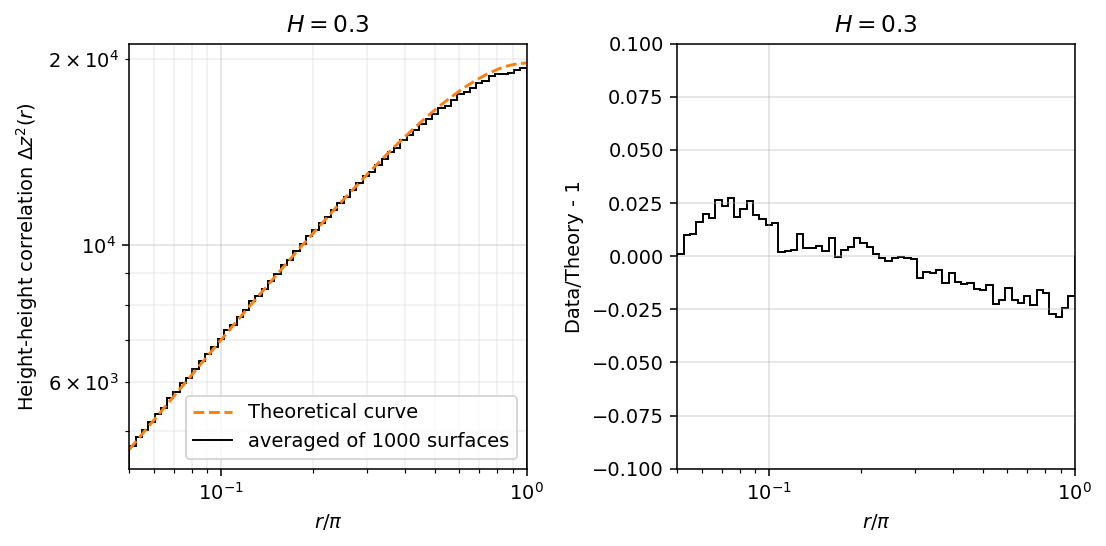

Generating points for spheres...
Finished generating pairs of points.
Calculating dz using 4 threads...
Calculating theoretical curve...


 44%|████▍     | 7/16 [00:15<00:21,  2.38s/it]c:\Users\taave\miniforge3\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
100%|██████████| 16/16 [00:36<00:00,  2.30s/it]


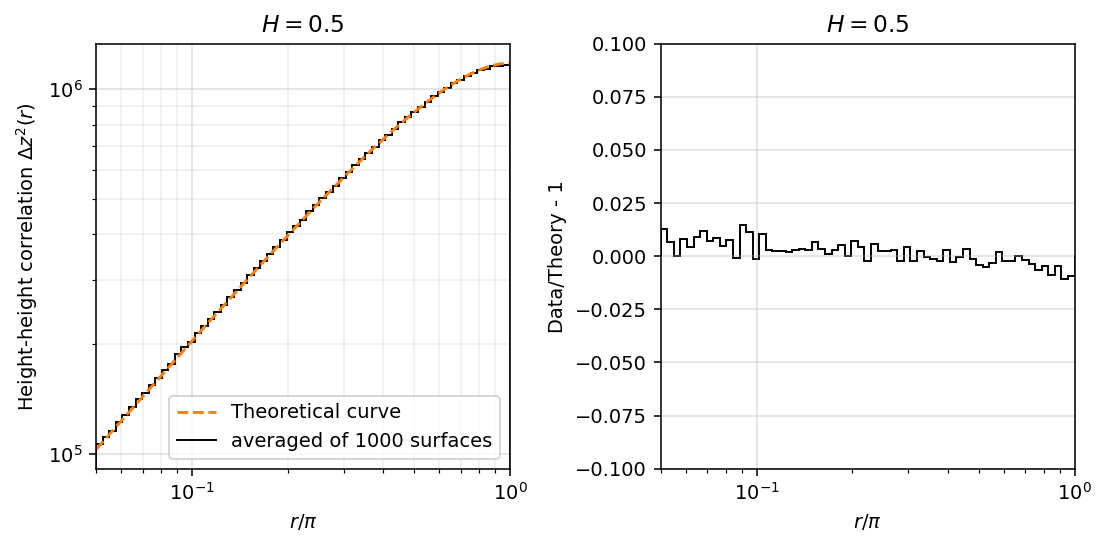

Generating points for spheres...
Finished generating pairs of points.
Calculating dz using 4 threads...
Calculating theoretical curve...


100%|██████████| 16/16 [00:23<00:00,  1.47s/it]


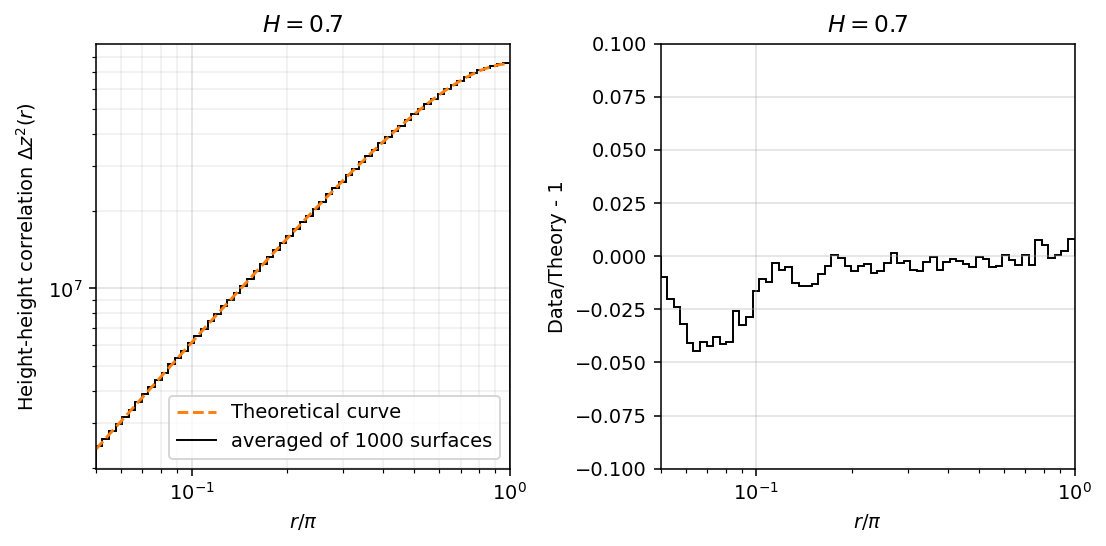

In [3]:
def calculate_dz(seeds, lon1, lon2, lat1, lat2, H, num_components, n_fbm, verbose=False):
    # Evaluates the height difference between two points on a surface with specified parameters.
    # The first half of the points correspond to the first point of the pair, the second half for the second.
    dz = []
    for i in tqdm(range(len(seeds)), disable=not verbose):
        sphere = fbs.SphericalFractionalBrownianSurface(
            n_fbm=n_fbm, H=H, num_components=num_components, seed=seeds[i], verbose=False
        )
        z_points = sphere.evaluate_points(
            np.concatenate([lon1[i], lon2[i]], axis=0), np.concatenate([lat1[i], lat2[i]], axis=0), n_threads=1, verbose=False
        )
        dz.append(z_points[:len(z_points)//2] - z_points[len(z_points)//2:])
    return np.concatenate(dz, axis=0)

def generate_dz_data(r_min, r_max, n_per_sphere, n_spheres, H, n_threads, seed=1):
    # Generating n_per_grid pairs of points on n_grid surfaces where the distances
    # between the points is log-uniformly distributed
    print(f'Generating points for spheres...')
    rng = np.random.default_rng(seed)
    dz, lat1, lat2, lon1, lon2 = [], [], [], [], []
    for i in range(n_spheres):
        # lon and lat are uniformly distributed on the sphere
        lon = rng.uniform(0, 2*np.pi, 2*n_per_sphere)
        lat = np.arcsin(rng.uniform(-1, 1, 2*n_per_sphere))
        # v is the cartesian coordinates of the points
        v = np.stack([np.cos(lat)*np.cos(lon), np.cos(lat)*np.sin(lon), np.sin(lat)], axis=1)

        # r is the angle between the pairs of points and is log-uniformly distributed between r_min and r_max
        rs = np.exp(rng.uniform(np.log(r_min), np.log(r_max), n_per_sphere))

        # We first start with the pairs of points randomly distributed on the sphere,
        # then we 'expand' or 'contract' the angle seperating the points to match rs
        # This is done by moving the second point on the plane defined by the two points and the origin
        v1, v2 = v[:n_per_sphere,:], v[n_per_sphere:,:]
        v2 = v2 - np.sum(v1*v2, axis=1)[:,None]*v1
        v2 /= np.linalg.norm(v2, axis=1)[:,None]
        v2 = np.cos(rs)[:,None] * v1 + np.sin(rs)[:,None] * v2
        v[n_per_sphere:,:] = v2
        lon[n_per_sphere:] = np.arctan2(v2[:,1], v2[:,0])
        lat[n_per_sphere:] = np.arcsin(v2[:,2])

        lon1.append(lon[:n_per_sphere])
        lon2.append(lon[n_per_sphere:])
        lat1.append(lat[:n_per_sphere])
        lat2.append(lat[n_per_sphere:])
    print('Finished generating pairs of points.')

    if n_threads > 1:
        from multiprocessing.pool import ThreadPool 
        print(f'Calculating dz using {n_threads} threads...')

        with ThreadPool(n_threads) as p:
            dz = p.starmap(calculate_dz, [(*x, H, 50, 1024*64) for x in zip(np.array_split(np.arange(n_spheres), n_threads), np.array_split(lon1, n_threads), np.array_split(lon2, n_threads), np.array_split(lat1, n_threads), np.array_split(lat2, n_threads))])
        dz = np.concatenate(dz, axis=0)
    else:
        dz = calculate_dz(np.arange(n_spheres), lon1, lon2, lat1, lat2, H, 50, 1024*64)

    lat1 = np.concatenate(lat1, axis=0)
    lat2 = np.concatenate(lat2, axis=0)
    lon1 = np.concatenate(lon1, axis=0)
    lon2 = np.concatenate(lon2, axis=0)

    return dz, lat1, lat2, lon1, lon2

for H in [0.3, 0.5, 0.7]:
    n_spheres = 1000
    n = 10000
    r_min, r_max = np.pi/20, np.pi
    dz, lat1, lat2, lon1, lon2 = generate_dz_data(r_min, r_max, n, n_spheres, H, n_threads=4)
    r_theory, dz2_theory = calculate_theoretical_curve(H, r_min, r_max, n_points=16)

    dz2 = dz**2
    # Find the distance along the sphere
    rs = np.arccos(np.sin(lat1)*np.sin(lat2) + np.cos(lat1)*np.cos(lat2)*np.cos(lon1 - lon2))

    r_bins = np.exp(np.linspace(np.log(r_min), np.log(r_max), 64))
    r_bins_center = 0.5*(r_bins[1:] + r_bins[:-1])
    # bin average values of dz2 using binned_statistic
    dz2_bins, *_ = binned_statistic(rs, dz2, bins=r_bins, statistic='mean')
    dz2_bins = np.nan_to_num(dz2_bins)


    fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=140, layout='tight')
    # Fit a coeficient to the theory curve based on data
    theory_coef = np.polyfit(np.log(r_theory), np.log(dz2_theory), 1)
    c1 = np.polyfit(np.log(r_bins_center[r_bins_center<0.6]), np.log(dz2_bins[r_bins_center<0.6]), 1)[1]
    c2 = np.polyfit(np.log(r_theory[r_theory<0.6]), np.log(dz2_theory[r_theory<0.6]), 1)[1]
    theory_coef = np.exp(c1 - c2)

    axs[0].plot(r_theory/np.pi, theory_coef*dz2_theory, color='tab:orange', ls='--', label=f'Theoretical curve', lw=1.5, alpha=1)
    axs[0].stairs(dz2_bins, r_bins/np.pi, fill=False, label=f'averaged of {n_spheres} surfaces', color='black', lw=1, alpha=1)
    axs[0].legend()
    axs[0].set_ylabel('Height-height correlation $\\Delta z^2(r)$')
    axs[0].set_yscale('log')
    for ax in axs:
        ax.set_xscale('log')
        ax.set_xlabel('$r/\\pi$')
        ax.set_xlim(r_min/np.pi, r_max/np.pi)
        ax.grid(alpha=0.4)
        ax.set_title(f'$H={H}$')
    axs[0].grid(which='minor', alpha=0.2)

    theory_interp = interp1d(r_theory, theory_coef*dz2_theory)(r_bins_center)
    axs[1].stairs(dz2_bins/theory_interp - 1, r_bins/np.pi, fill=False, color='black', lw=1, alpha=1)
    axs[1].set_xlabel('$r/\\pi$')
    axs[1].set_ylabel('Data/Theory - 1')
    axs[1].set_xscale('log')
    axs[1].set_ylim(-0.1, 0.1)
    plt.show()